In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

def get_results(X,y,groups):
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [1000],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
                 'rf__probability':[False]
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=5)
    grid_search.fit(X[:,:],y)
    clf = grid_search.best_estimator_
    y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20)
    print(classification_report(y,y_pred))
    return np.array([f1_score(y,y_pred),precision_score(y,y_pred),recall_score(y,y_pred)])

def get_label(user_data,st,et):
    label = 2
    for k in range(user_data.shape[0]):
        if st>=user_data[k,0] and et<=user_data[k,1]:
            label = user_data[k,2]

    return label

def get_ecg_windowss(rr_interval,window=0):
    window_col,ts_col = [],[]
    if window==0:
        n = 30
    else:
        n = (.5*60)/(window/2)
    ts_array = np.arange(rr_interval[0,0],rr_interval[-1,0],30000)
    for t in ts_array:
        index = np.where((rr_interval[:,0]>=t)&(rr_interval[:,0]<=t+60000))[0]
        if len(index)<n:
            continue
        rr_temp = rr_interval[index,:]
        window_col.append(rr_temp)
        ts_col.append(t)
    return window_col,ts_col

def get_rr_features(a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


def combine_data_sobc(window_col,ts_col,label_data,participant):
    feature_matrix = []
    user_col = []
    label_col = []
    for i,item in enumerate(window_col):
        feature = get_rr_features(item[:,1])
        feature_matrix.append(feature.reshape(-1,7))
        user_col.append(participant)
        label_col.append(get_label(label_data,ts_col[i],ts_col[i]+50000))
    return np.array(feature_matrix).reshape(-1,7),user_col,label_col

def get_2_sec_ts(rr_ppg_int,window=2):
    m = np.mean(rr_ppg_int[:,1])
    s = np.std(rr_ppg_int[:,1])
    ts_array = np.arange(rr_ppg_int[0,0],rr_ppg_int[-1,0],1000*window/2)
    rr_interval = np.zeros((0,2))
    for t in ts_array:
        index = np.where((rr_ppg_int[:,0]>=t-1000*window//2)&(rr_ppg_int[:,0]<=t+1000*window//2))[0]
        if len(index) < 1:
            continue
        rr_interval = np.concatenate((rr_interval,np.array([t,np.mean(rr_ppg_int[index,1])]).reshape(-1,2)))
    return rr_interval


def get_precision_recall_f1(path,window):
    participants = os.listdir(path)
    X,y,groups = np.zeros((0,7)),[],[]
    for participant in participants:
        file_list = os.listdir(path+'/'+participant)
        for file in file_list:
            final_path = path+'/'+participant+'/'+file+'/'
            try:
                if 'ecg_rr_pan_tomkins1.csv' not in os.listdir(final_path):
                    continue
                else:
                    ecg_rr = pd.read_csv(final_path+'ecg_rr_pan_tomkins1.csv',header=None,sep=',').values
                if ecg_rr.shape[0]<500:
                    continue
                winsor_limit = .02
                ecg_rr[:,1] = winsorize(ecg_rr[:,1],limits=[winsor_limit,winsor_limit])
                if window>0:
                    ecg_rr = get_2_sec_ts(ecg_rr,window)
                label_data = pd.read_csv(final_path+'label_data.csv',header=None,sep=',').values
                window_col,ts_col = get_ecg_windowss(ecg_rr,window)
                feature_matrix,user_col,label_col = combine_data_sobc(window_col,ts_col,label_data,participant)
#                 print(feature_matrix.shape)
                rr_70th = np.percentile(feature_matrix[:,2],60)
                rr_95th = np.percentile(feature_matrix[:,2],99)
                index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
                means = np.mean(feature_matrix[index],axis=0)
                stds = np.std(feature_matrix[index],axis=0)
                feature_matrix = (feature_matrix - means)/stds
                temp = np.array(label_col)
                labels = np.array(label_col)
                X = np.concatenate((X,feature_matrix))
                y.extend(label_col)
                groups.extend(user_col)
            except Exception as e:
                print(e)
    y = np.array(y)
    groups = np.array(groups)
    index = np.where(y<2)[0]
    X,y,groups = X[index],y[index],groups[index]
#     print(X.shape,len(y),sum(y))
    return get_results(X,y,groups)
            

In [3]:
from scipy.stats.mstats_basic import winsorize
import pickle
path = '/home/jupyter/mullah/Test/data_yield/data/sobc_2nd_chance//'
all_results = []
for duration in [0]+list(np.arange(2,16,1)):
    temp = get_precision_recall_f1(path,duration)
    temp = [duration]+list(temp)
    all_results.append(np.array(temp))
    pickle.dump(all_results,open('../data/rice/stress_results.p','wb'))
    print(temp)

Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   56.2s finished


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      2350
         1.0       0.78      0.71      0.75       836

    accuracy                           0.87      3186
   macro avg       0.84      0.82      0.83      3186
weighted avg       0.87      0.87      0.87      3186

[0, 0.7460815047021944, 0.7839262187088274, 0.7117224880382775]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   51.4s finished


              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      2360
         1.0       0.76      0.73      0.74       835

    accuracy                           0.87      3195
   macro avg       0.83      0.82      0.83      3195
weighted avg       0.87      0.87      0.87      3195

[2, 0.7429620563035495, 0.7596996245306633, 0.7269461077844311]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   49.1s finished


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2364
         1.0       0.74      0.74      0.74       837

    accuracy                           0.86      3201
   macro avg       0.82      0.82      0.82      3201
weighted avg       0.86      0.86      0.86      3201

[3, 0.7398081534772183, 0.7424789410348978, 0.7371565113500598]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   48.9s finished


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2368
         1.0       0.75      0.75      0.75       839

    accuracy                           0.87      3207
   macro avg       0.83      0.83      0.83      3207
weighted avg       0.87      0.87      0.87      3207

[4, 0.7520858164481525, 0.7520858164481525, 0.7520858164481525]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   50.9s finished


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2368
         1.0       0.75      0.75      0.75       840

    accuracy                           0.87      3208
   macro avg       0.83      0.83      0.83      3208
weighted avg       0.87      0.87      0.87      3208

[5, 0.7488095238095238, 0.7488095238095238, 0.7488095238095238]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   53.0s finished


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2369
         1.0       0.75      0.74      0.75       843

    accuracy                           0.87      3212
   macro avg       0.83      0.83      0.83      3212
weighted avg       0.87      0.87      0.87      3212

[6, 0.7455410225921522, 0.7473182359952324, 0.7437722419928826]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   49.5s finished


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2368
         1.0       0.74      0.75      0.75       842

    accuracy                           0.87      3210
   macro avg       0.83      0.83      0.83      3210
weighted avg       0.87      0.87      0.87      3210

[7, 0.7466196355085244, 0.7392316647264261, 0.7541567695961995]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   51.0s finished


              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      2370
         1.0       0.71      0.79      0.75       843

    accuracy                           0.86      3213
   macro avg       0.81      0.84      0.82      3213
weighted avg       0.87      0.86      0.86      3213

[8, 0.7458006718924972, 0.7062566277836692, 0.7900355871886121]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   51.4s finished


              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      2370
         1.0       0.71      0.78      0.74       847

    accuracy                           0.86      3217
   macro avg       0.82      0.83      0.82      3217
weighted avg       0.86      0.86      0.86      3217

[9, 0.7446569178852642, 0.7110633727175081, 0.781582054309327]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   51.5s finished


              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2371
         1.0       0.79      0.73      0.76       847

    accuracy                           0.88      3218
   macro avg       0.85      0.83      0.84      3218
weighted avg       0.88      0.88      0.88      3218

[10, 0.7588739290085679, 0.7878017789072427, 0.731995277449823]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   50.8s finished


              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      2369
         1.0       0.77      0.73      0.75       846

    accuracy                           0.87      3215
   macro avg       0.84      0.83      0.83      3215
weighted avg       0.87      0.87      0.87      3215

[11, 0.74802671523983, 0.7690387016229713, 0.7281323877068558]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   50.5s finished


              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2371
         1.0       0.79      0.73      0.76       848

    accuracy                           0.88      3219
   macro avg       0.85      0.83      0.84      3219
weighted avg       0.87      0.88      0.88      3219

[12, 0.7577791336180598, 0.7850821744627055, 0.7323113207547169]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   53.4s finished


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      2369
         1.0       0.79      0.72      0.75       847

    accuracy                           0.88      3216
   macro avg       0.85      0.83      0.84      3216
weighted avg       0.87      0.88      0.87      3216

[13, 0.753390875462392, 0.7883870967741935, 0.7213695395513577]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   51.4s finished


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      2368
         1.0       0.78      0.71      0.75       847

    accuracy                           0.87      3215
   macro avg       0.84      0.82      0.83      3215
weighted avg       0.87      0.87      0.87      3215

[14, 0.7464528069093153, 0.7816537467700259, 0.7142857142857143]
Fitting 31 folds for each of 64 candidates, totalling 1984 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 1984 out of 1984 | elapsed:   52.6s finished


              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      2373
         1.0       0.76      0.77      0.76       850

    accuracy                           0.87      3223
   macro avg       0.84      0.84      0.84      3223
weighted avg       0.87      0.87      0.87      3223

[15, 0.7618490345231129, 0.7578579743888242, 0.7658823529411765]


In [4]:
all_results = pickle.load(open('../data/rice/stress_results.p','rb'))

In [5]:
df = np.array(all_results)

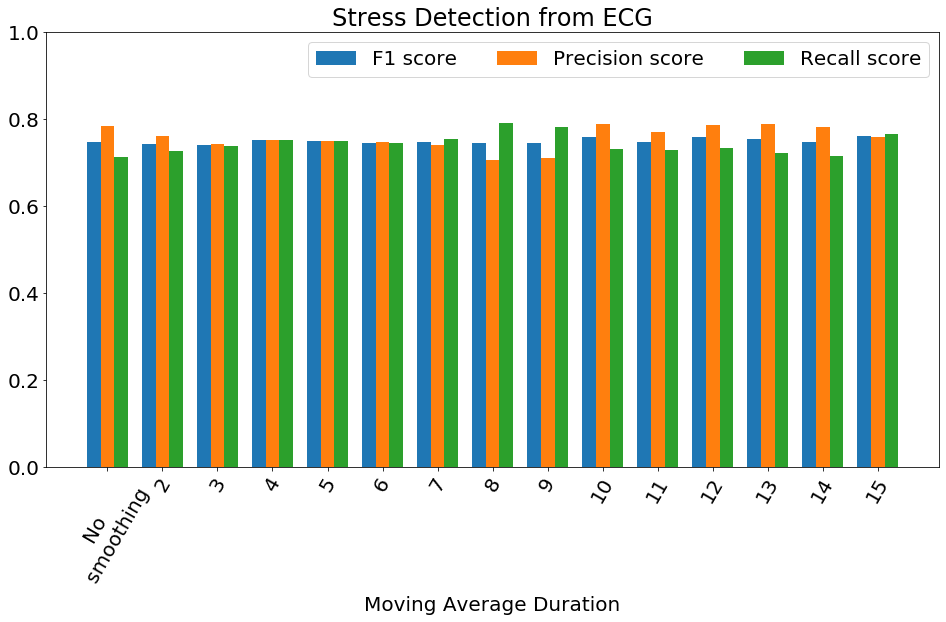

In [19]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,8))
plt.bar(np.array(range(0,df.shape[0]*4,4)),df[:,1],1,label='F1 score')
plt.bar(np.array(range(1,df.shape[0]*4,4)),df[:,2],1,label='Precision score')
plt.bar(np.array(range(2,df.shape[0]*4,4)),df[:,3],1,label='Recall score')
plt.xticks(np.array(range(1,df.shape[0]*4,4)),['No \n smoothing']+list(np.arange(2,16,1)),rotation=60)
plt.xlabel('Moving Average Duration')
plt.legend(ncol=3)
plt.title('Stress Detection from ECG')
plt.ylim([0,1])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
y = np.array(y)
groups = np.array(groups)
y = y[~np.isnan(X).any(axis=1)]
groups = groups[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
print(X.shape,len(np.unique(groups)))
for user in np.unique(groups):
    index = np.where(groups==user)[0]
    X[index,:] = StandardScaler().fit_transform(X[index,:])
# X[X>4] = 4
# X[X<-4] = -4
index = np.where(y<2)[0]
X,y,groups = X[index],y[index],groups[index]
print(X.shape,len(np.unique(groups)))

In [ ]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed

delta = 0.1

paramGrid = {'rf__kernel': ['rbf'],
             'rf__C': [11,1000],
             'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
             'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
             'rf__probability':[True]
}
pca = PCA(n_components=4)
clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='accuracy',verbose=5)
grid_search.fit(X[:,:],y)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20)
print(classification_report(y,y_pred))

In [ ]:
import pickle
print(clf)
clf.fit(X,y)
pickle.dump(clf,open('../models/stress_model_ecg_2.p','wb'))

In [ ]:
# from sklearn.metrics import plot_confusion_matrix
# import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mats = confusion_matrix(y,y_pred)
mats
# sns.set(font_scale=1.5)
# df_cm = pd.DataFrame(mats, index = [i for i in ['Not Stress','Stress']],
#                   columns = [i for i in ['Not Stress','Stress']])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True,fmt='g',annot_kws={"fontsize":28})
# plt.show()

In [ ]:
### from sklearn.decomposition import PCA
from pprint import pprint
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
warnings.filterwarnings('ignore')
from sklearn import metrics

def Twobias_scorer_CV(probs, y, ret_bias=False):
    db = np.transpose(np.vstack([np.array(probs).reshape(-1), np.array(y).reshape(-1)]))
    db = db[np.argsort(db[:, 0]), :]

    pos = np.sum(y == 1)
    n = len(y)
    neg = n - pos
    tp, tn = pos, 0
    lost = 0

    optbias = []
    minloss = 1

    for i in range(n):
        #		p = db[i,1]
        if db[i, 1] == 1:  # positive
            tp -= 1.0
        else:
            tn += 1.0

        # v1 = tp/pos
        #		v2 = tn/neg
        if tp / pos >= 0.95 and tn / neg >= 0.95:
            optbias = [db[i, 0], db[i, 0]]
            continue

        running_pos = pos
        running_neg = neg
        running_tp = tp
        running_tn = tn

        for j in range(i + 1, n):
            #			p1 = db[j,1]
            if db[j, 1] == 1:  # positive
                running_tp -= 1.0
                running_pos -= 1
            else:
                running_neg -= 1

            lost = (j - i) * 1.0 / n
            if running_pos == 0 or running_neg == 0:
                break

            # v1 = running_tp/running_pos
            #			v2 = running_tn/running_neg

            if running_tp / running_pos >= 0.95 and running_tn / running_neg >= 0.95 and lost < minloss:
                minloss = lost
                optbias = [db[i, 0], db[j, 0]]

    if ret_bias:
        return -minloss, optbias
    else:
        return -minloss
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    parameters : dict or None
        Parameters to be set on the estimator.
    cv:	Cross-validation fold indeces
    Returns
    -------
    score : float
        CV score on whole set.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    estimator.set_params(**parameters)
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)

    return [score, parameters]  # scoring_time
    
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    probs = cross_val_predict(estimator, X, y, cv=cv,method='predict_proba')[:,1]
#     for train, test in cv:
#         temp = estimator.fit(X[train], y[train]).predict_proba(X[test])
#         probs[test] = temp[:, 1]

    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise'):

        super(ModifiedGridSearchCV, self).__init__(
                estimator, param_grid, scoring, fit_params, n_jobs, iid,
                refit, cv, verbose, pre_dispatch, error_score)

    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
#         cv = check_cv(cv, X, y, classifier=is_classifier(estimator))

        if self.verbose > 0:
#             if isinstance(parameter_iterable, Sized):
            n_candidates = len(parameter_iterable)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv)
                for parameters in parameter_iterable)
#         print(out)
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]

        if self.refit:
            # fit the best estimator using the entire dataset
            # clone first to work around broken estimators
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
#             if y is not None:
#                 best_estimator.fit(X, y, **self.fit_params)
#             else:
#                 best_estimator.fit(X, **self.fit_params)
            self.best_estimator_ = best_estimator

        return self

In [ ]:
gkf = GroupKFold(n_splits=len(np.unique(groups)))
X1 = preprocessing.StandardScaler().fit_transform(X)
delta = 0.1
parameters1 = {'kernel': ['rbf'],
              'C': np.logspace(0,2,2),
              'gamma': np.logspace(-9,9,10),
              'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
              'probability':[True],
              'verbose':[False],
              'cache_size':[2000]}
parameters = {
    'min_samples_leaf': [4],
    'max_features': [.7,1],
    'n_estimators': [100,200,300],
    'n_jobs': [-1],
    'criterion':['gini','entropy'],
    'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
    'random_state': [42]
       }
svc = SVC()
# svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups), 
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
grid_search = ModifiedGridSearchCV(svc, parameters1, cv=list(gkf.split(X1,y,groups=groups)),
                                   n_jobs=20, scoring=f1Bias_scorer_CV, verbose=1, iid=False)
grid_search.fit(X1,y)
clf = grid_search.best_estimator_
clf

In [ ]:
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
clf.probability = True
CV_probs = cross_val_probs(clf, X1, y, gkf.split(X1,y,groups=groups))
# score, bias = Twobias_scorer_CV(CV_probs, y, True)
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
classified = range(n)
print(score,bias)

f = np.zeros((len(y),2))

data = pd.DataFrame()
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

data['groups'] = groups
data['original'] = [[i] for i in y]
data['predicted'] = [[i] for i in predicted]
f_scores = []
data = data.groupby('groups').sum()
for i in range(data.shape[0]):
    f_scores.append(f1_score(data['original'][i],data['predicted'][i]))
print(np.median(f_scores))

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
def plot_confusion_matrix(cm, classes=['Not Stress','Stress'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('result.png')
    plt.show()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
predicted = cross_val_predict(clf, X, y, cv=gkf.split(X,y,groups=groups),n_jobs=24)
plot_confusion_matrix(confusion_matrix(y,predicted))
print(f1_score(y,predicted),precision_score(y,predicted),recall_score(y,predicted))

In [ ]:
from sklearn.feature_selection import RFECV
svc = predictor
gkf = GroupKFold(n_splits=len(np.unique(groups)))
rfecv = RFECV(estimator=svc, step=1, cv=gkf.split(X,y,groups=groups),
              scoring='f1',n_jobs=24)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
np.power(2,-1)

In [ ]:
import xgboost

In [ ]:
a = np.array([[1/2,1/3,1/6],[0,1/3,2/3],[1/2,0,1/2]])

In [ ]:
np.matmul(np.matmul(a,a),a)

In [ ]:
np.float.as_integer_ratio(0.36111111)